# Project Overview

## OSEMN Pipeline

* O - Obtaining our data - in OS_dataset_cleanup
* S - Scrubbing/Cleaning our data - in OS_dataset_cleanup
* E - Exploring/Visualizing our data
* M - Modeling our data
* N - Interpreting the data

## Package Imports

In [35]:
# basic tools
import pandas as pd
import numpy as np
import time
from collections import Counter

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split

# scoring and algorithm selection packages
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, cross_val_score, HalvingGridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score

# resampling packages
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler, OneSidedSelection, NeighbourhoodCleaningRule

# model packages
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
import xgboost as xgb

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.plot
%matplotlib inline

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')


## Notebook Functions

### TO DO write docstrings

In [2]:
def spot_check_model(model, train, test, y_train, y_test, title):
    
    start=time.time()
    
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    # get accuracy cross val score for cv 3
    cv_5 = cross_val_score(model, train, y_train, scoring='accuracy', cv=3)
    accs = round(cv_5.mean()*100,2)
    print("CV 5 Accuracy Train Score: {}".format(accs))
    
    # make predictions on test data
    preds = model.predict(test)
    
    # Print Testing accuracy
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    print('\nTesting Accuracy: ', accuracy)
    print('Testing f1 Score: ', f1)
    print('Testing AUC Score: ', auc, '\n')
    
    
    print(classification_report(y_test, preds))
    
    # append our results to our lists
    spot_check['Model'].append(title)
    spot_check['f1'].append(f1)
    spot_check['accuracy'].append(accuracy)
    spot_check['auc'].append(auc)
    
    print(f'Elapsed Time: {time.time() - start}') 

In [3]:
def make_model(model, train, test, y_train, y_test, title):
    
    start=time.time()
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    # get accuracy cross val score for cv 5
    cv_5 = cross_val_score(model, train, y_train, scoring='accuracy', cv=5)
    accs = round(cv_5.mean()*100,2)
    print("CV 5 Accuracy Train Score: {}".format(accs))
    
    # make predictions on test data
    preds = model.predict(test)
    
    # Print Testing accuracy
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    print('\nTesting Accuracy: ', accuracy)
    print('Testing f1 Score: ', f1)
    print('Testing AUC Score: ', auc, '\n')
    
    
    print(classification_report(y_test, preds))
    
    # Visualize Confusion Matrix
    print("\nConfusion Matrix for Test Set")
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title('Confusion Matrx')
    plot_confusion_matrix(model, test, y_test, cmap=plt.cm.Blues, ax=ax)
    plt.show()
    
    # Get false positive, true positive, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # Visualize AUC
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    plt.figure(figsize=(15,10))
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # Calculate our scores
    

    # append our results to our lists
    models['Model'].append(title)
    models['f1'].append(f1)
    models['accuracy'].append(accuracy)
    models['auc'].append(auc)
    
    print(f'Elapsed Time: {time.time() - start}')

In [4]:
def grid_optimizer(model, grid, x, y):
    
    start=time.time()
    
    print("Making Search")
    grid_search = HalvingGridSearchCV(model, grid, verbose=10, scoring='roc_auc', cv=3, n_jobs=-1, min_resources='exhaust')

    print("Running Grid")
    grid_search.fit(x, y)

    grid_search.best_estimator_
    
    # Best f1
    print('Best roc_auc: %.3f' % grid_search.best_score_)

    print("Best parameters set found on train set: \n")
    print(grid_search.best_params_)
    print("\nGrid scores on train set:\n")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return grid_search.best_params_

In [5]:
'''class TargetEncoder(BaseEstimator, TransformerMixin):
    
    def _init_(self):
        print("Initializing a TargetEncoder")
        
    def fit(self, x, y=None):
        # what do I need to happen when I FIT this?
    
    def transform(self, x, y=None):
        # what do I need to happen when I TRANSFORM this?
        # transform actually returns something'''

'class TargetEncoder(BaseEstimator, TransformerMixin):\n    \n    def _init_(self):\n        print("Initializing a TargetEncoder")\n        \n    def fit(self, x, y=None):\n        # what do I need to happen when I FIT this?\n    \n    def transform(self, x, y=None):\n        # what do I need to happen when I TRANSFORM this?\n        # transform actually returns something'

# Exploring/Visualizing Data

In [ ]:
final = pd.read_pickle("data/pkl/small_train_test.pkl")

In [ ]:
final

In [ ]:
final.dropna(inplace=True, axis=0)

In [ ]:
print('Raw counts: \n')
print(final['DEP_DEL15'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(final['DEP_DEL15'].value_counts(normalize=True))

In [ ]:
sns.countplot(x=final['DEP_DEL15'], data=final.drop('DEP_DEL15', axis=1))
plt.show()

In [ ]:
final.groupby('DEP_DEL15').mean()

In [ ]:
plt.figure(figsize=(30,20))
ax = plt.axes()
ax.set_facecolor("lightgrey")
sns.scale=2

sns.scatterplot(data=final, x="LONGITUDE", y="LATITUDE", hue="DEP_DEL15", palette="magma_r");

In [ ]:
sns.set(font_scale = 1.5) #increasing our font size a bit


g = sns.catplot(
    data=final, kind="bar",
    x="CARRIER_NAME", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Airline", "Percent Delayed Flights");


In [ ]:
final.groupby('CARRIER_NAME').mean().sort_values('DEP_DEL15', ascending=False)

In [ ]:
sns.set(font_scale = 1.5) #increasing our font size a bit


g = sns.catplot(
    data=final, kind="bar",
    x="DAY_OF_WEEK", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Day of Week", "Percent Delayed Flights");


In [ ]:
sns.set(font_scale = 1.5) #increasing our font size a bit

g = sns.catplot(
    data=final, kind="bar",
    x="CARRIER_NAME", y="DEP_DEL15", 
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Airline", "Percent Delayed Flights");


In [ ]:
sns.set(font_scale = 1.5) #increasing our font size a bit

g = sns.catplot(
    data=final, kind="bar",
    x="DEPARTING_AIRPORT", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Airport", "Delays by Airport");


In [ ]:
# highest delay by airport
final.groupby('DEPARTING_AIRPORT').mean().sort_values('DEP_DEL15', ascending=False).head(10)

In [ ]:
# lowest delay by airport
final.groupby('DEPARTING_AIRPORT').mean().sort_values('DEP_DEL15', ascending=True).head(10)

In [ ]:
# highest delay by grouping of airport and carrier
final.groupby(['DEPARTING_AIRPORT', 'CARRIER_NAME'])['DEP_DEL15'].describe().sort_values('mean', ascending=False).head(30)

In [ ]:
# lowest delay by grouping of airport and carrier
final.groupby(['DEPARTING_AIRPORT', 'CARRIER_NAME'])['DEP_DEL15'].describe().sort_values('mean', ascending=True).head(30)

In [ ]:
sns.set(font_scale = 1.5) #increasing our font size a bit

g = sns.catplot(
    data=final, kind="bar",
    x="MONTH", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Delays by Month");


In [ ]:
final.groupby('MONTH').mean().sort_values('DEP_DEL15', ascending=False)

In [ ]:
sns.set(font_scale = 1.5) #increasing our font size a bit

g = sns.catplot(
    data=final, kind="bar",
    x="SEGMENT_NUMBER", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Segment Number", "Delays by Segment Number");


# Multicollinearity, Train/Test Split and Processing

In [6]:
final = pd.read_pickle("data/pkl/small_train_test.pkl")

In [7]:
final

,MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE_GROUP,DEP_BLOCK,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,2,MORNING,1,109,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
1,1,7,0,7,MORNING,1,109,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
2,1,7,0,7,MORNING,1,109,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
3,1,7,0,9,MORNING,1,109,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
4,1,7,0,7,EARLY_MORNING,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502045,1,2,0,1,EVENING,11,6,123,Hawaiian Airlines Inc.,2092,...,18,Kahului Airport,20.901,-156.434,Honolulu International,0.01,0.0,0.0,79.0,11.86
502046,1,2,0,1,EVENING,11,6,123,Hawaiian Airlines Inc.,2092,...,18,Kahului Airport,20.901,-156.434,Honolulu International,0.01,0.0,0.0,79.0,11.86
502047,1,2,0,1,LATE_NIGHT,12,12,123,Hawaiian Airlines Inc.,2092,...,19,Kahului Airport,20.901,-156.434,Honolulu International,0.01,0.0,0.0,79.0,11.86
502048,1,2,0,1,LATE_NIGHT,13,12,123,Hawaiian Airlines Inc.,2092,...,18,Kahului Airport,20.901,-156.434,Honolulu International,0.01,0.0,0.0,79.0,11.86


## Target Encode

### TO DO make lookup table

In [8]:
# Add target encoding
final['CARRIER_HISTORICAL'] = final.groupby(['CARRIER_NAME', 'MONTH'])['DEP_DEL15'].transform('mean')
final['PREV_AIRPORT_HISTORICAL'] = final.groupby(['PREVIOUS_AIRPORT', 'MONTH'])['DEP_DEL15'].transform('mean')
final['DEP_AIRPORT_HISTORICAL'] = final.groupby(['DEPARTING_AIRPORT', 'MONTH'])['DEP_DEL15'].transform('mean')
final['DAY_HISTORICAL'] = final.groupby(['DAY_OF_WEEK', 'MONTH'])['DEP_DEL15'].transform('mean')
final['DEP_BLOCK_HISTORICAL'] = final.groupby(['DEP_BLOCK', 'MONTH'])['DEP_DEL15'].transform('mean')
  
final.drop(columns=['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_BLOCK', 'MONTH'], axis=1, inplace=True) 

## MultiCollinearity

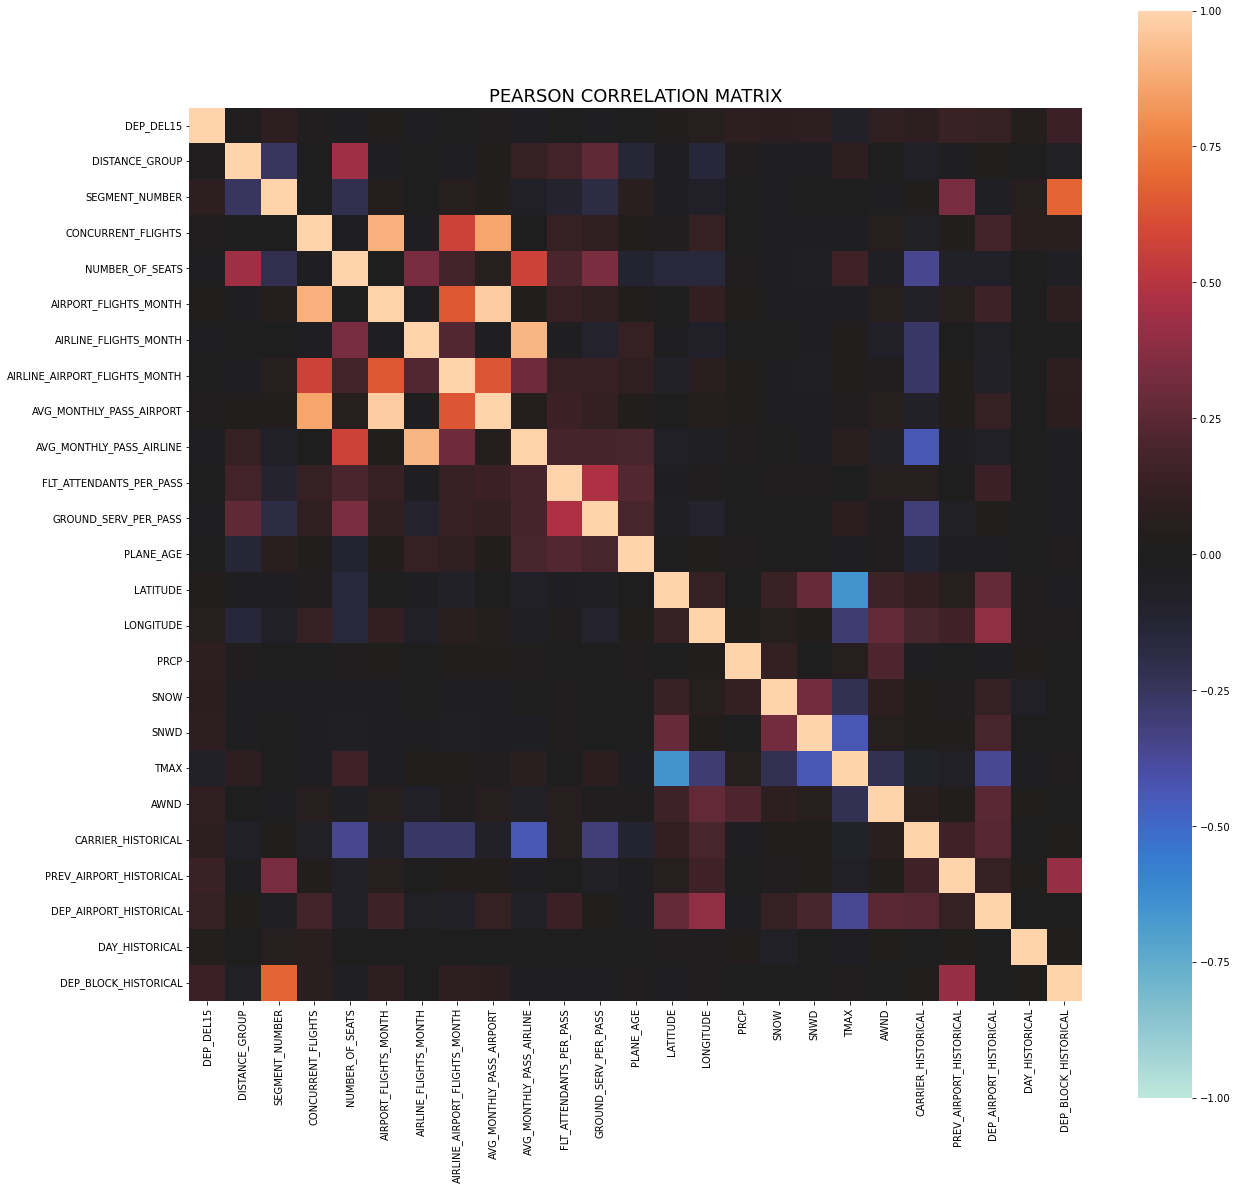

In [9]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(final.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [10]:
final.corr()

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,...,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,PREV_AIRPORT_HISTORICAL,DEP_AIRPORT_HISTORICAL,DAY_HISTORICAL,DEP_BLOCK_HISTORICAL
DEP_DEL15,1.000000,0.008018,0.093747,0.014315,-0.029276,0.018294,-0.023757,-0.014453,0.014449,-0.039574,...,0.081789,0.076356,0.079394,-0.082127,0.095296,0.091092,0.138395,0.121161,0.040739,0.143115
DISTANCE_GROUP,0.008018,1.000000,-0.253112,-0.012632,0.436098,-0.018885,-0.011921,-0.042251,0.030084,0.120310,...,0.008522,-0.020276,-0.031913,0.083623,-0.009633,-0.075340,-0.033772,0.017217,-0.011578,-0.061173
SEGMENT_NUMBER,0.093747,-0.253112,1.000000,0.001077,-0.203275,0.042594,0.007709,0.056481,0.025790,-0.074749,...,-0.013507,-0.016056,-0.003065,0.004845,-0.032574,0.020651,0.328797,-0.051743,0.049337,0.683169
CONCURRENT_FLIGHTS,0.014315,-0.012632,0.001077,1.000000,-0.019948,0.894142,-0.041501,0.566926,0.864357,0.003949,...,-0.001545,-0.044472,-0.031118,-0.038012,0.053749,-0.062230,0.038918,0.178813,0.065363,0.068854
NUMBER_OF_SEATS,-0.029276,0.436098,-0.203275,-0.019948,1.000000,0.002394,0.330690,0.174607,0.053698,0.568307,...,0.013746,-0.029654,-0.052226,0.160892,-0.053237,-0.356196,-0.080472,-0.075950,-0.010963,-0.048180
AIRPORT_FLIGHTS_MONTH,0.018294,-0.018885,0.042594,0.894142,0.002394,1.000000,-0.038860,0.645343,0.975121,0.016137,...,0.023175,-0.020364,-0.019959,-0.019235,0.056688,-0.072643,0.050780,0.150986,0.003758,0.080856
AIRLINE_FLIGHTS_MONTH,-0.023757,-0.011921,0.007709,-0.041501,0.330690,-0.038860,1.000000,0.223493,-0.023184,0.906463,...,0.003691,-0.003037,-0.032819,0.031266,-0.073287,-0.260804,-0.000121,-0.055119,0.000217,-0.007202
AIRLINE_AIRPORT_FLIGHTS_MONTH,-0.014453,-0.042251,0.056481,0.566926,0.174607,0.645343,0.223493,1.000000,0.633533,0.303456,...,0.030285,-0.037261,-0.051109,0.026373,0.014179,-0.262027,0.029612,-0.080010,0.003208,0.080438
AVG_MONTHLY_PASS_AIRPORT,0.014449,0.030084,0.025790,0.864357,0.053698,0.975121,-0.023184,0.633533,1.000000,0.040032,...,0.029856,-0.028745,-0.037204,0.008043,0.050705,-0.080907,0.038603,0.119253,0.001327,0.073634
AVG_MONTHLY_PASS_AIRLINE,-0.039574,0.120310,-0.074749,0.003949,0.568307,0.016137,0.906463,0.303456,0.040032,1.000000,...,0.013052,-0.011511,-0.044899,0.063925,-0.058220,-0.434437,-0.024577,-0.064404,-0.000327,-0.024276


In [11]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = final.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 95% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


,level_0,level_1,correlation
pairs,,,
"(AIRLINE_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRLINE)",AIRLINE_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRLINE,0.906463
"(AVG_MONTHLY_PASS_AIRLINE, AIRLINE_FLIGHTS_MONTH)",AVG_MONTHLY_PASS_AIRLINE,AIRLINE_FLIGHTS_MONTH,0.906463
"(AIRPORT_FLIGHTS_MONTH, CONCURRENT_FLIGHTS)",AIRPORT_FLIGHTS_MONTH,CONCURRENT_FLIGHTS,0.894142
"(CONCURRENT_FLIGHTS, AIRPORT_FLIGHTS_MONTH)",CONCURRENT_FLIGHTS,AIRPORT_FLIGHTS_MONTH,0.894142
"(CONCURRENT_FLIGHTS, AVG_MONTHLY_PASS_AIRPORT)",CONCURRENT_FLIGHTS,AVG_MONTHLY_PASS_AIRPORT,0.864357
"(AVG_MONTHLY_PASS_AIRPORT, CONCURRENT_FLIGHTS)",AVG_MONTHLY_PASS_AIRPORT,CONCURRENT_FLIGHTS,0.864357


In [12]:
final.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT'], axis=1, inplace=True)

In [13]:
# Check out our variables correlationg with price
df_correlations = final.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'DEP_DEL15'].sort_values(0, ascending=False)

,level_0,level_1,0
0,DEP_DEL15,DEP_DEL15,1.000000
21,DEP_DEL15,DEP_BLOCK_HISTORICAL,0.143115
18,DEP_DEL15,PREV_AIRPORT_HISTORICAL,0.138395
19,DEP_DEL15,DEP_AIRPORT_HISTORICAL,0.121161
16,DEP_DEL15,AWND,0.095296
2,DEP_DEL15,SEGMENT_NUMBER,0.093747
17,DEP_DEL15,CARRIER_HISTORICAL,0.091092
15,DEP_DEL15,TMAX,0.082127
12,DEP_DEL15,PRCP,0.081789
14,DEP_DEL15,SNWD,0.079394


In [14]:
#final.drop(['LATITUDE','LONGITUDE'], axis=1, inplace=True)

In [15]:
final.dtypes

DEP_DEL15                           int8
DISTANCE_GROUP                      int8
SEGMENT_NUMBER                      int8
CONCURRENT_FLIGHTS                 int64
NUMBER_OF_SEATS                    int16
AIRLINE_FLIGHTS_MONTH              int64
AIRLINE_AIRPORT_FLIGHTS_MONTH      int64
FLT_ATTENDANTS_PER_PASS          float64
GROUND_SERV_PER_PASS             float64
PLANE_AGE                          int32
LATITUDE                         float64
LONGITUDE                        float64
PRCP                             float64
SNOW                             float64
SNWD                             float64
TMAX                             float64
AWND                             float64
CARRIER_HISTORICAL               float64
PREV_AIRPORT_HISTORICAL          float64
DEP_AIRPORT_HISTORICAL           float64
DAY_HISTORICAL                   float64
DEP_BLOCK_HISTORICAL             float64
dtype: object

* Split into Train/Test
* Create custom transformer ???
* Convert Carrier, Departing Airport, Previous Airport, Day of Week, Dep_block into CONTINUOUS values, grouping on Month, on TRAIN set
* Convert same fields on TEST using TRAIN data only
* Eliminate Carrier, Departing Airport, Previous Airport, Month, Day of Week

## Train/Test Split

In [16]:
randomstate = 42
testsize = .3

# Define appropriate X and y

predictors = final.drop(['DEP_DEL15'], axis=1)
y = final['DEP_DEL15']

x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=testsize, random_state=randomstate, stratify=y)

## Processing Pipelines

In [17]:
features_cat = [col for col in x_train.columns if x_train[col].dtype in [object]]

cont_features = [col for col in x_train.columns if x_train[col].dtype in [np.float64, np.int64, np.int32, np.int16, np.int8]]

poly_features = ['SEGMENT_NUMBER']

features_cat, cont_features, poly_features

([],
 ['DISTANCE_GROUP',
  'SEGMENT_NUMBER',
  'CONCURRENT_FLIGHTS',
  'NUMBER_OF_SEATS',
  'AIRLINE_FLIGHTS_MONTH',
  'AIRLINE_AIRPORT_FLIGHTS_MONTH',
  'FLT_ATTENDANTS_PER_PASS',
  'GROUND_SERV_PER_PASS',
  'PLANE_AGE',
  'LATITUDE',
  'LONGITUDE',
  'PRCP',
  'SNOW',
  'SNWD',
  'TMAX',
  'AWND',
  'CARRIER_HISTORICAL',
  'PREV_AIRPORT_HISTORICAL',
  'DEP_AIRPORT_HISTORICAL',
  'DAY_HISTORICAL',
  'DEP_BLOCK_HISTORICAL'],
 ['SEGMENT_NUMBER'])

In [52]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [55]:
get_feature_names(data_transforms)

NameError: name 'data_transforms' is not defined

In [57]:
def pipeline_fit_preprocessor(x):
    
    # Create a column transformer to one hot encode the categoricals
    print("Setting up transforms - OHE, Polynomials, StandardScaler")
    data_transforms = ColumnTransformer(transformers=[
        #("ohe", OneHotEncoder(handle_unknown="ignore"), features_cat),
        ("polys", PolynomialFeatures(degree=2), poly_features),
        ('scl', StandardScaler(with_mean=False), cont_features)
        ], remainder="passthrough")

    print('Setting up processing pipeline')
    pipe = Pipeline([
                ('transforms', data_transforms),
            ])
    
    print('Fitting pipeline on train data')
    transformed_data = pipe.fit_transform(x)
    
    return transformed_data, pipe

def pipeline_transform_preprocessor(x, pipe):
    
    print('Transforming test data')
    transformed_data = pipe.transform(x)
    return transformed_data


In [58]:
processed_train, pipe = pipeline_fit_preprocessor(x_train)
processed_test = pipeline_transform_preprocessor(x_test, pipe)

Setting up transforms - OHE, Polynomials, StandardScaler
Setting up processing pipeline
Fitting pipeline on train data
Transforming test data


In [59]:
processed_train.shape

(351435, 24)

In [ ]:
mapper = umap.UMAP().fit(processed_train)

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
umap.plot.points(mapper, theme='viridis', ax=ax);

In [ ]:
umap.plot.connectivity(mapper, show_points=True)

In [ ]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

In [ ]:
local_dims = umap.plot.diagnostic(mapper, diagnostic_type='local_dim')

# Modeling

Using the framework proposed at https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

Model Plans:

Linear Algorithms: 
* Logistic Regression
* Naive Bayes

Nonlinear Algorithms: 
* Decision Trees
* SVM
* KNN

Ensemble Algorithms: 
* Extra Trees
* Random Forest
* XGBoost
* CatBoost
* AdaBoost
* Gradient Boosted Trees

Feature Selection Plans:

* Basic Correlation
* RFECV
* Permutation Importance

In [21]:
# prepare dictionary to store testing results

spot_check = {}
spot_check['Model'] = []
spot_check['f1'] = []
spot_check['accuracy'] = []
spot_check['auc'] = []

models = {}
models['Model'] = []
models['f1'] = []
models['accuracy'] = []
models['auc'] = []

## Spot Check Baseline Algorithms

We run the basic algorithms with no hyperparameter tuning, to get a feel for their baseline performance.

In [36]:
baseline_models = {
    "Logistic Regression": LogisticRegression(random_state=randomstate, fit_intercept=False, C=1e12),
    "Perceptron": Perceptron(),
    "Naive Bayes" : GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors = 1),
    "Extra Trees" : ExtraTreesClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(verbosity=0),
    "CatBoost": CatBoostClassifier(verbose=False),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}



for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check_model(this_model, processed_train, processed_test, y_train, y_test, label)



Running Perceptron Classification
CV 5 Accuracy Train Score: 78.06

Testing Accuracy:  0.8252896457856124
Testing f1 Score:  0.042918454935622324
Testing AUC Score:  0.5088052986528595 

              precision    recall  f1-score   support

           0       0.83      1.00      0.90    124310
           1       0.50      0.02      0.04     26305

    accuracy                           0.83    150615
   macro avg       0.66      0.51      0.47    150615
weighted avg       0.77      0.83      0.75    150615

Elapsed Time: 2.541306495666504


Running Naive Bayes Classification
CV 5 Accuracy Train Score: 78.43

Testing Accuracy:  0.7852073166683265
Testing f1 Score:  0.28097704087302466
Testing AUC Score:  0.5704056817506423 

              precision    recall  f1-score   support

           0       0.85      0.90      0.87    124310
           1       0.34      0.24      0.28     26305

    accuracy                           0.79    150615
   macro avg       0.59      0.57      0.58  

## Spot-Check Imbalanced Algorithms

Spot check the same baseline algorithms, but after using various balancing methods, both on the data directly and with class_weight

### Cost-Balanced class weights

In [24]:
counts = Counter(y_train)
scale_weight = counts[0]/counts[1]

weighted_models = {
    "Logistic Regression_Weighted": LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12),
    "Perceptron": Perceptron(class_weight='balanced', random_state=randomstate),
    "Decision Tree Classifier_Weighted": DecisionTreeClassifier(class_weight='balanced', random_state=randomstate),
    "Extra Trees_Weighted" : ExtraTreesClassifier(class_weight='balanced', random_state=randomstate),
    "Random Forest_Weighted": RandomForestClassifier(class_weight='balanced', random_state=randomstate),
    "XGBoost_Weighted": xgb.XGBClassifier(scale_pos_weight=scale_weight, random_state=randomstate, verbosity=0),
    "CatBoost_Weighted": CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False),
}

for model in weighted_models:
    this_model = baseline_models[model]
    label = model
    spot_check_model(this_model, processed_train, processed_test, y_train, y_test, label)



Running Logistic Regression_Weighted Classification
CV 5 Accuracy Train Score: 63.25

Testing Accuracy:  0.635799887129436
Testing f1 Score:  0.37248038071704764
Testing AUC Score:  0.6291355547400208 

              precision    recall  f1-score   support

           0       0.89      0.64      0.74    124310
           1       0.27      0.62      0.37     26305

    accuracy                           0.64    150615
   macro avg       0.58      0.63      0.56    150615
weighted avg       0.78      0.64      0.68    150615

Elapsed Time: 8.403635740280151


Running Decision Tree Classifier_Weighted Classification
CV 5 Accuracy Train Score: 75.9

Testing Accuracy:  0.7624804966304817
Testing f1 Score:  0.3180709111704155
Testing AUC Score:  0.5869385466623891 

              precision    recall  f1-score   support

           0       0.86      0.86      0.86    124310
           1       0.32      0.32      0.32     26305

    accuracy                           0.76    150615
   macro 

### Data Undersampling

TomekLinks - closest pairs of opposite classification neighbors. The majority class of these pairs is removed. TomekLinks gets rid of noisy/ambiguous data.

NearMiss - Version of NearMiss must be specified(1-3). 1) keeps only majority samples closest to minority samples. 2) keeps only majority samples that are furthest from minority samples. 3) selects the closest examples from majority for each minority

RandomUnderSampler - Picks majority samples to use entirely at random


In [ ]:
catboost_weighted = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False)

In [32]:
tl = TomekLinks(sampling_strategy='majority')
x_tl, y_tl = tl.fit_resample(processed_train, y_train)

spot_check_model(catboost_weighted, x_tl, processed_test, y_tl, y_test, "Catboost_Weighted_TomekLinks")



Running XGBoost_Weighted_TomekLinks Classification
CV 5 Accuracy Train Score: 69.96

Testing Accuracy:  0.6814593499983401
Testing f1 Score:  0.4213294093524226
Testing AUC Score:  0.6745691522278056 

              precision    recall  f1-score   support

           0       0.91      0.69      0.78    124310
           1       0.31      0.66      0.42     26305

    accuracy                           0.68    150615
   macro avg       0.61      0.67      0.60    150615
weighted avg       0.80      0.68      0.72    150615

Elapsed Time: 20.463573694229126


In [37]:
nm = NearMiss(version=2)
x_nm, y_nm = nm.fit_resample(processed_train, y_train)

spot_check_model(catboost_weighted, x_nm, processed_test, y_nm, y_test, "Catboost_Weighted_NearMiss")

MemoryError: Unable to allocate 1.00 GiB for an array with shape (2186, 61377) and data type float64

In [ ]:
rus = RandomUnderSampler(random_state=randomstate, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(processed_train, y_train)

spot_check_model(catboost_weighted, x_rus, processed_test, y_rus, y_test, "Catboost_Weighted_RandomUnderSampler")

### Data Oversampling

SMOTE creates synthetic data from the minority class, adding minor variations so that it is not simply duplicates of minority data.

In [38]:
smote = SMOTE()
processed_train_resampled, y_train_resampled = smote.fit_resample(processed_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

spot_check_model(catboost_weighted, processed_train_resampled, processed_test, y_train_resampled, y_test, "Catboost_Weighted_SMOTE")

-----------------------------------------
Synthetic sample class distribution: 

1    290058
0    290058
Name: DEP_DEL15, dtype: int64


Running XGBoost_Weighted_SMOTE Classification
CV 5 Accuracy Train Score: 71.32

Testing Accuracy:  0.6468811207383063
Testing f1 Score:  0.40461664185203017
Testing AUC Score:  0.6627027892311884 

              precision    recall  f1-score   support

           0       0.91      0.64      0.75    124310
           1       0.29      0.69      0.40     26305

    accuracy                           0.65    150615
   macro avg       0.60      0.66      0.58    150615
weighted avg       0.80      0.65      0.69    150615

Elapsed Time: 38.8574059009552


### Combination Under/Oversampling

TomekLinks + Condensed Nearest Neighbor = OneSidedSelection
    - One step process. Identifies TomekLinks, which are closest pairs of opposite classification neighbors. The majority class of these pairs is removed. CNN then gets rid of redundant majority class examples that are far from the class boundary. When used together, TomekLinks gets rid of noisy/ambiguous data, and then CNN gets rid of redundant but decisive majority data.

Condensed Nearest Neighbor + Edited Nearest Neighbor = NeighbourhoodCleaning Rule
    - This process does CNN first (rather than second like OneSided). Redundant but decisive majority data is removed. Then ENN removes the noisy/ambiguous examples using a K-Nearest Neighbors algorithm with default of 3 neighbors. This method usually results in less cut data. 
    
Both of these are then used with SMOTE to oversample the minority data.

In [39]:
oss = OneSidedSelection(n_neighbors=1, n_seeds_S=500, ratio='majority')
x_oss, y_oss = oss.fit_resample(processed_train, y_train)

smote2 = SMOTE()
processed_train_samplecombo, y_train_samplecombo = smote2.fit_resample(x_oss, y_oss) 

spot_check_model(catboost_weighted, processed_train_samplecombo, processed_test, y_train_samplecombo, y_test, "Catboost_Weighted_OneSided_SMOTE")



Running XGBoost_Weighted_OneSided_SMOTE Classification
CV 5 Accuracy Train Score: 69.79

Testing Accuracy:  0.6202038309597318
Testing f1 Score:  0.40014261595411127
Testing AUC Score:  0.6616320691242077 

              precision    recall  f1-score   support

           0       0.91      0.60      0.72    124310
           1       0.28      0.73      0.40     26305

    accuracy                           0.62    150615
   macro avg       0.59      0.66      0.56    150615
weighted avg       0.80      0.62      0.67    150615

Elapsed Time: 35.7594633102417


In [42]:
ncr = NeighbourhoodCleaningRule(n_neighbors=1, sampling_strategy='majority', kind_sel='all', n_jobs=-1)
x_ncr, y_ncr = ncr.fit_resample(processed_train, y_train)

smote2 = SMOTE()
processed_train_samplecombo, y_train_samplecombo = smote2.fit_resample(x_ncr, y_ncr) 

spot_check_model(catboost_weighted, processed_train_samplecombo, processed_test, y_train_samplecombo, y_test, "Catboost_Weighted_Neighbourhood_SMOTE")



Running XGBoost_Weighted_Neighbourhood_SMOTE Classification
CV 5 Accuracy Train Score: 68.76

Testing Accuracy:  0.5783886067124788
Testing f1 Score:  0.3887610815389503
Testing AUC Score:  0.6530091709735172 

              precision    recall  f1-score   support

           0       0.92      0.54      0.68    124310
           1       0.26      0.77      0.39     26305

    accuracy                           0.58    150615
   macro avg       0.59      0.65      0.53    150615
weighted avg       0.80      0.58      0.63    150615

Elapsed Time: 32.03107309341431


### Imbalanced Methods Evaluation

In [ ]:
spot_check_chart = pd.DataFrame(spot_check)
spot_check_chart.sort_values('f1', ascending=False)

## Feature Selection

### Permutation Importance

### PCA

In [ ]:
pca_all = PCA(n_components=processed_train.shape[1], random_state=randomstate)
x_pca = pca_all.fit_transform(processed_train)

print("Explained variance with all components is ", sum(pca_all.explained_variance_ratio_ * 100))
print("1 component explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[0])
print("1st and 2nd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[1])
print("1st to 3rd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[2])
print("1st to 4th components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[3])

plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
#plt.savefig('images/pca.png')

In [ ]:
pca_2 = PCA(n_components=2, random_state=randomstate)
x_pca_2 = pca_2.fit_transform(processed_train)

print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=x_pca_2[:,0], y=x_pca_2[:,1], s=70, hue=y_train, palette=['yellow', 'blue'])
plt.title("2D Plot of 91.31% Variability")
plt.xlabel("First Component")
plt.ylabel("Second Component")

In [ ]:
pca_95th = PCA(n_components=.95, random_state=randomstate)
x_pca_95 = pca_95th.fit_transform(processed_train)
x_pca_95th_test = pca_95th.transform(processed_test)

x_pca_95.shape

In [ ]:
spot_check_model(catboost_weighted, x_pca_95, x_pca_95th_test, y_train, y_test, "Catboost_Weighted_PCA")

## Evaluate Spot Checks

In [63]:
chart = pd.DataFrame(spot_check)
chart.sort_values('auc', ascending=False)

,Model,f1,accuracy,auc
14,CatBoost_Weighted,0.435156,0.714497,0.681067
13,XGBoost_Weighted,0.429465,0.709405,0.676618
18,XGBoost_Weighted_TomekLinks,0.421329,0.681459,0.674569
21,XGBoost_Weighted_SMOTE,0.404617,0.646881,0.662703
22,XGBoost_Weighted_OneSided_SMOTE,0.400143,0.620204,0.661632
23,XGBoost_Weighted_Neighbourhood_SMOTE,0.388761,0.578389,0.653009
9,Logistic Regression_Weighted,0.372480,0.635800,0.629136
1,Decision Tree Classifier,0.329259,0.754785,0.593096
17,test2,0.328293,0.754905,0.592509
4,Random Forest,0.309355,0.833303,0.589083


## Hyperparameter Tuned Best Algorithms

Select the Top 5 performers and tune these

We'll tune:

* CatBoost Weighted
* XGBoost Weighted
* XGBoost Weighted with TomekLinks
* XGBoost Weighted with SMOTE
* Logistic Regression Weighted
* Decision Tree Classifier

In [ ]:
counts = Counter(y_train)
scale_weight = counts[0]/counts[1]


xgbc = xgb.XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate, 
                         verbose=0, 
                         objective= 'binary:logistic', 
                         tree_method = 'hist',
                        eta = .01,
                        gamma = .1,
                        max_depth = 10,
                        subsample = .9,
                        min_child_weight = 1,
                        n_estimators = 500,
                        colsample_bytree = .6,
                        reg_lambda = 1,
                        alpha = 1,
                        max_delta_step = 1,
                        num_parallel_tree = 10)



In [ ]:
spot_check_model(xgbc, processed_train, processed_test, y_train, y_test, "XGBoost_Weighted_Optimized")

In [ ]:
spot_check_chart = pd.DataFrame(spot_check)
spot_check_chart.sort_values('auc', ascending=False)

In [ ]:
break

In [ ]:
dtc = DecisionTreeClassifier(criterion = 'gini', max_depth= 50, min_samples_leaf= 10, min_samples_split= 10)

make_model(dtc, processed_train, processed_test, y_train, y_test, "Decision Tree Classifier")

In [ ]:
model = RandomForestClassifier(max_depth= 50, min_samples_leaf= 10, min_samples_split= 10)

make_model(model, processed_train, processed_test, y_train, y_test, "Random Forest Classifier")

In [ ]:
model = GradientBoostingClassifier()

make_model(model, processed_train, processed_test, y_train, y_test, "Gradient Boosting Classifier")

In [ ]:
xgbc = xgb.XGBClassifier()

make_model(xgbc, processed_train, processed_test, y_train, y_test, "XGBoost")

## Model Selection

# Above and Beyond Plan

* Custom Transformer
* Unit testing
* stacked ensemble model 
* 

# HYPERPARAMETER TUNING

## CatBoost

In [ ]:
#Parameter Tuning

param_grid = {'depth':[7],
          'iterations':[1000],
          'learning_rate':[.01, .03, 0.05], 
          'l2_leaf_reg':[75, 100, 125],
          'border_count':[150, 254],
        'random_strength':[0,1],
        'bagging_temperature':[0,1],

          }


cats = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, thread_count=4)

In [ ]:
best_params = grid_optimizer(cats, param_grid, processed_train, y_train)
best_params

{'border_count': 50,
 'depth': 5,
 'iterations': 500,
 'l2_leaf_reg': 10,
 'learning_rate': 0.05}

Best roc_auc: 0.723
Best parameters set found on train set: 

{'border_count': 50, 'depth': 5, 'iterations': 500, 'l2_leaf_reg': 10, 'learning_rate': 0.05}

border, l2, iterations higher bounds
learning centered
depth lower bound

Best parameters set found on train set: 

{'border_count': 150, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 100, 'learning_rate': 0.05}

border, l2, depth higher bounds


Best parameters set found on train set: 

{'border_count': 150, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 100, 'learning_rate': 0.05}

Well centered


Best parameters set found on train set: 

{'bagging_temperature': 0.1, 'border_count': 254, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 125, 'learning_rate': 0.03, 'random_strength': 0.1}

Best roc_auc: 0.722
Best parameters set found on train set: 

{'bagging_temperature': 1, 'border_count': 150, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 75, 'learning_rate': 0.01, 'random_strength': 0.1

## XGBoost

In [ ]:
#Parameter Tuning
counts = Counter(y_train)
scale_weight = counts[0]/counts[1]


param_grid = {
            'eta': [.01, .05],
            'gamma': [.1],
            'max_depth': [10, 12, 14],
            'subsample': [.8, .9, .1],
            'min_child_weight': [1],
            'n_estimators': [500],
            'colsample_bytree' : [.6, .7, .8],
             }

xgbc = xgb.XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate, 
                         verbose=2, 
                         objective= 'binary:logistic', 
                         tree_method = 'hist')

In [ ]:
best_params = grid_optimizer(xgbc, param_grid, processed_train, y_train)
best_params

Best roc_auc: 0.739
Best parameters set found on train set: 

{'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.9}

In [ ]:
#Parameter Tuning
counts = Counter(y_train)
scale_weight = counts[0]/counts[1]


param_grid = {
            'lambda': [1, 10],
            'alpha': [1, 10],    
            'max_delta_step': [1, 3],
            'num_parallel_tree': [10, 50],
             }

xgbc = xgb.XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate, 
                         verbose=2, 
                         objective= 'binary:logistic', 
                         tree_method = 'hist',
                        eta = .01,
                        gamma = .1,
                        max_depth = 10,
                        subsample = .9,
                        min_child_weight = 1,
                        n_estimators = 500,
                        col_sample_by_tree = .6)

In [ ]:
best_params_2 = grid_optimizer(xgbc, param_grid, processed_train, y_train)
best_params_2

est roc_auc: 0.739
Best parameters set found on train set: 

{'alpha': 1, 'lambda': 1, 'max_delta_step': 1, 'num_parallel_tree': 10}

## Other

In [ ]:
#Parameter Tuning

param_grid = {'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [10, 50, 100, 1000],
        'max_depth': [5,10,25,50],
        'min_samples_split': [50, 100, 1000],
        'class_weight' : ['balanced']
        }

clf = DecisionTreeClassifier()

grid_search = GridSearchCV(clf, param_grid, verbose=10, scoring='f1', cv=5, n_jobs=-1)

grid_search.fit(processed_train, y_train)

grid_search.best_estimator_


# Best accuracy
print('Best f1: %.3f' % grid_search.best_score_)

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

## KNN

In [ ]:

mae_val = [] #to store mae values for different k

# checks mean absolute error scores on k from 1 to 20
for K in range(10):
    K = K+1
    
    # set up the KNN regressor
    model = KNeighborsClassifier(n_neighbors = K)

    model.fit(processed_train, y_train)  #fit the model
    pred=model.predict(processed_test) #make prediction on test set
    error = accuracy_score(y_test,pred) #calculate accuracy
    f1 = f1_score(y_test,pred)
    mae_val.append(f1) #store mae values
    print('Accuracy value for k= ' , K , 'is:', error)
    print('F1 value for k= ' , K , 'is:', f1)
    
# gets optimal k-value based on score minimum
index_max = np.argmax(mae_val) + 1



# DEPRECATED

* Identify tiers/sets of parameters to iterate, by importance
* For each set of parameters:

    
    * All parameters should be Try/Except so that if the model doesn't use it, it is simply skipped
    * Send initial set of test parameters
    * Array of .1 to 1 by .1, for multiplier
    * For each multiplier in array: 
        
        
        * Run GridSearch on set of parameters
        * Get back dictionary of best value per parameters
        * For each parameter:
        
            
            * Check if best parameter is same as upper or lower bound of previous best parameter. If so, multiply parameter by some amount and make new upper and lower bound to try a new general area for the parameter
            * Have bounding rules per parameter, that the upper and lower cannot exceed
            * Use dictionary to make new set of parameters, using best value with multiplier
            * Make sure new parameters are in correct format (whole numbers etc)
            * Make list of new parameter set, and append to dictionary
            * Set new dictionary of parameters

In [ ]:
best_params = {'eta': 0.1,
 'gamma': 0.2,
 'max_depth': 8,
 'min_child_weight': 1,
 'n_estimators': 500,
 'subsample': 0.8}

best_params

multiplier = .5

for line in best_params:
    actual = best_params[line]
    lower = round((actual*(1-multiplier)), 2)
    upper = round((actual*(1+multiplier)), 2)
    
    parameters = []

    parameters.append(lower)
    parameters.append(actual)
    parameters.append(upper)
    best_params[line] = parameters
        
best_params

In [ ]:
grid_search.best_params_['gamma']

## MULTICLASS STUFF

In [ ]:
#final = final[final['DELAY'] != '0']
#final.drop(['DEP_DEL15'], axis=1, inplace=True)

final['HISTORICAL'] = final.groupby(['DISPLAY_AIRPORT_NAME', 'CARRIER_NAME'])['DEP_DEL15'].transform('mean')
#final.drop('DISPLAY_AIRPORT_NAME', axis=1, inplace=True)
#final.drop('CARRIER_NAME', axis=1, inplace=True)

#final.drop(['DEP_DEL15'], axis=1, inplace=True)

#predictors = final.drop(['DELAY'], axis=1)
#y = final['DELAY']

#le = LabelEncoder()
#y = le.fit_transform(y)
#n_classes = y.nunique()

In [ ]:
model_multiclass = LogisticRegression(solver='saga',
                                multi_class= 'multinomial',
                                penalty='l1',
                                max_iter=7,
                                random_state=randomstate,
                               C=1e12,
                               fit_intercept=False
                                )

#make_model(model, processed_train, processed_test, y_train, y_test, "Log Reg")

make_model_multiclass(model_multiclass, processed_train, processed_test, y_train, y_test, "Log Reg")

## Estimator Helper Class

This code by David S. Bautista at http://www.davidsbatista.net/blog/2018/02/23/model_optimization/

In [ ]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=5, n_jobs=-1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [ ]:
models1 = {
    'Logistic Regression': LogisticRegression(),
    #'KNN' : KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Naive Bayes Classifier' : GaussianNB(),
    #'Random Forest Classifier': RandomForestClassifier(),
    #'Extra Trees Classifier': ExtraTreesClassifier(),
    #'AdaBoost Classifier': AdaBoostClassifier(),
    #'Gradient Boosting Classifier': GradientBoostingClassifier(),
    #'SVC': SVC(),
    #'XGBoost' : xgb.XGBClassifier()
}

params1 = {
    
    'Logistic Regression': {'solver': ['liblinear', 'lbfgs']},
    #'KNN' : {'n_neighbors' : [1,5,10]},
    'Decision Tree Classifier' : {'criterion' : ['gini', 'entropy'], 'max_depth':[1,3,5,7]},
    'Naive Bayes Classifier' : {},
    #'RandomForestClassifier': { 'max_depth':[1,3,5,7] },    
    #'ExtraTreesClassifier': { 'max_depth':[1,3,5,7] },
    #'AdaBoostClassifier':  { 'max_depth':[1,3,5,7] },
    #'GradientBoostingClassifier': { 'max_depth':[1,3,5,7], 'learning_rate': [0.8, 1.0] },
    #'SVC': {'kernel': ['rbf', 'linear'], 'C': [1, 10], 'gamma': [0.001]},
    #'XGBoost' : {'max_depth':[1,3,5,7]},    
    
}

In [ ]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(processed_train, y_train, scoring='accuracy', n_jobs=-1)

In [ ]:
helper1.score_summary(sort_by='max_score')

In [ ]:
# prepare dictionary to store results
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = []

In [ ]:
def make_model_log(model, train, test, y_train, y_test, title):
    
    model.fit(train, y_train)
    cv_5 = cross_val_score(model, train, y_train, cv=5)
    r2 = round(cv_5.mean()*100,2)
    
    test_predictions = model.predict(test)
    
    # reverse log transform our predicted values
    test_predictions_unscaled = np.exp(test_predictions).astype(int)
    test_predictions_unscaled = test_predictions_unscaled.flatten()
    
    test_actual = np.exp(y_test)
    
    # get residuals
    residuals = test_actual - test_predictions_unscaled

    fig = plt.figure(figsize=(20,15))
    plt.scatter(test_predictions_unscaled, residuals)
    plt.show()
    
    # Calculate our errors
    mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
    rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

    # append our results to our lists
    models['Models'].append(title)
    models['r2'].append(r2)
    models['mae'].append(mae)
    models['rmse'].append(rmse)

    print("R2: ", r2, "\nMAE: ", mae, "\nRMSE: ", rmse, "\n{} predictors used for this model".format(train.shape[1]))

In [ ]:
print(classification_report(y_test, y_hat_test))

In [ ]:
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, y_hat_test)


# Import plot_confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Visualize your confusion matrix
plot_confusion_matrix(logreg, x_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()


In [ ]:
# Fit SMOTE to training data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

In [ ]:
# Instantiate the model
logreg = LogisticRegression(class_weight='balanced', fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model
logreg.fit(X_train_resampled, y_train_resampled)

# Predict
y_hat_test = logreg.predict(x_test)

y_score = logreg.decision_function(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
print('AUC: {}'.format( auc(fpr, tpr)))

In [ ]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(classification_report(y_test, y_hat_test))